<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0"> </div>
    <div style="float: left; margin-left: 10px;"> <h1>Machine Learning with PyTorch for Developers</h1>
<h1>Machine Learning Overview</h1>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
            @bgoncalves, @data4sci</p></div>
</div>

In [12]:
from collections import Counter
from pprint import pprint

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 
import seaborn as sns

import torch

import watermark

%load_ext watermark
%matplotlib inline

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


We start by print out the versions of the libraries we're using for future reference

In [13]:
%watermark -n -v -m -g -iv

Python implementation: CPython
Python version       : 3.13.2
IPython version      : 9.0.0

Compiler    : Clang 16.0.0 (clang-1600.0.26.6)
OS          : Darwin
Release     : 24.3.0
Machine     : arm64
Processor   : arm
CPU cores   : 16
Architecture: 64bit

Git hash: 9fc8d0140a8bc745a378db69347b7f8d00e6f884

watermark : 2.5.0
pandas    : 2.2.3
numpy     : 2.2.3
matplotlib: 3.10.1
torch     : 2.6.0
seaborn   : 0.13.2



Load default figure style

In [14]:
plt.style.use('d4sci.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# K-Nearest Neighbors

Load the Penguin dataset from seaborn

In [15]:
penguins = sns.load_dataset("penguins").dropna()

In [16]:
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male


In [17]:
penguins['species'] = penguins.species.astype('category')
penguins['labels'] = penguins.species.cat.codes

In [18]:
penguin_colors = np.array(["#EE8132", "#BA61C4", "#347274"])

In [19]:
train = np.random.binomial(1, 0.25, size=penguins.shape[0])
X_train = penguins[train == 0][["bill_length_mm", "bill_depth_mm"]].copy()
y_train = penguins[train == 0]["labels"].copy()

X_test = penguins[train == 1][["bill_length_mm", "bill_depth_mm"]].copy()
y_test = penguins[train == 1]["labels"].copy()

Text(0, 0.5, 'Bill Depth (mm)')

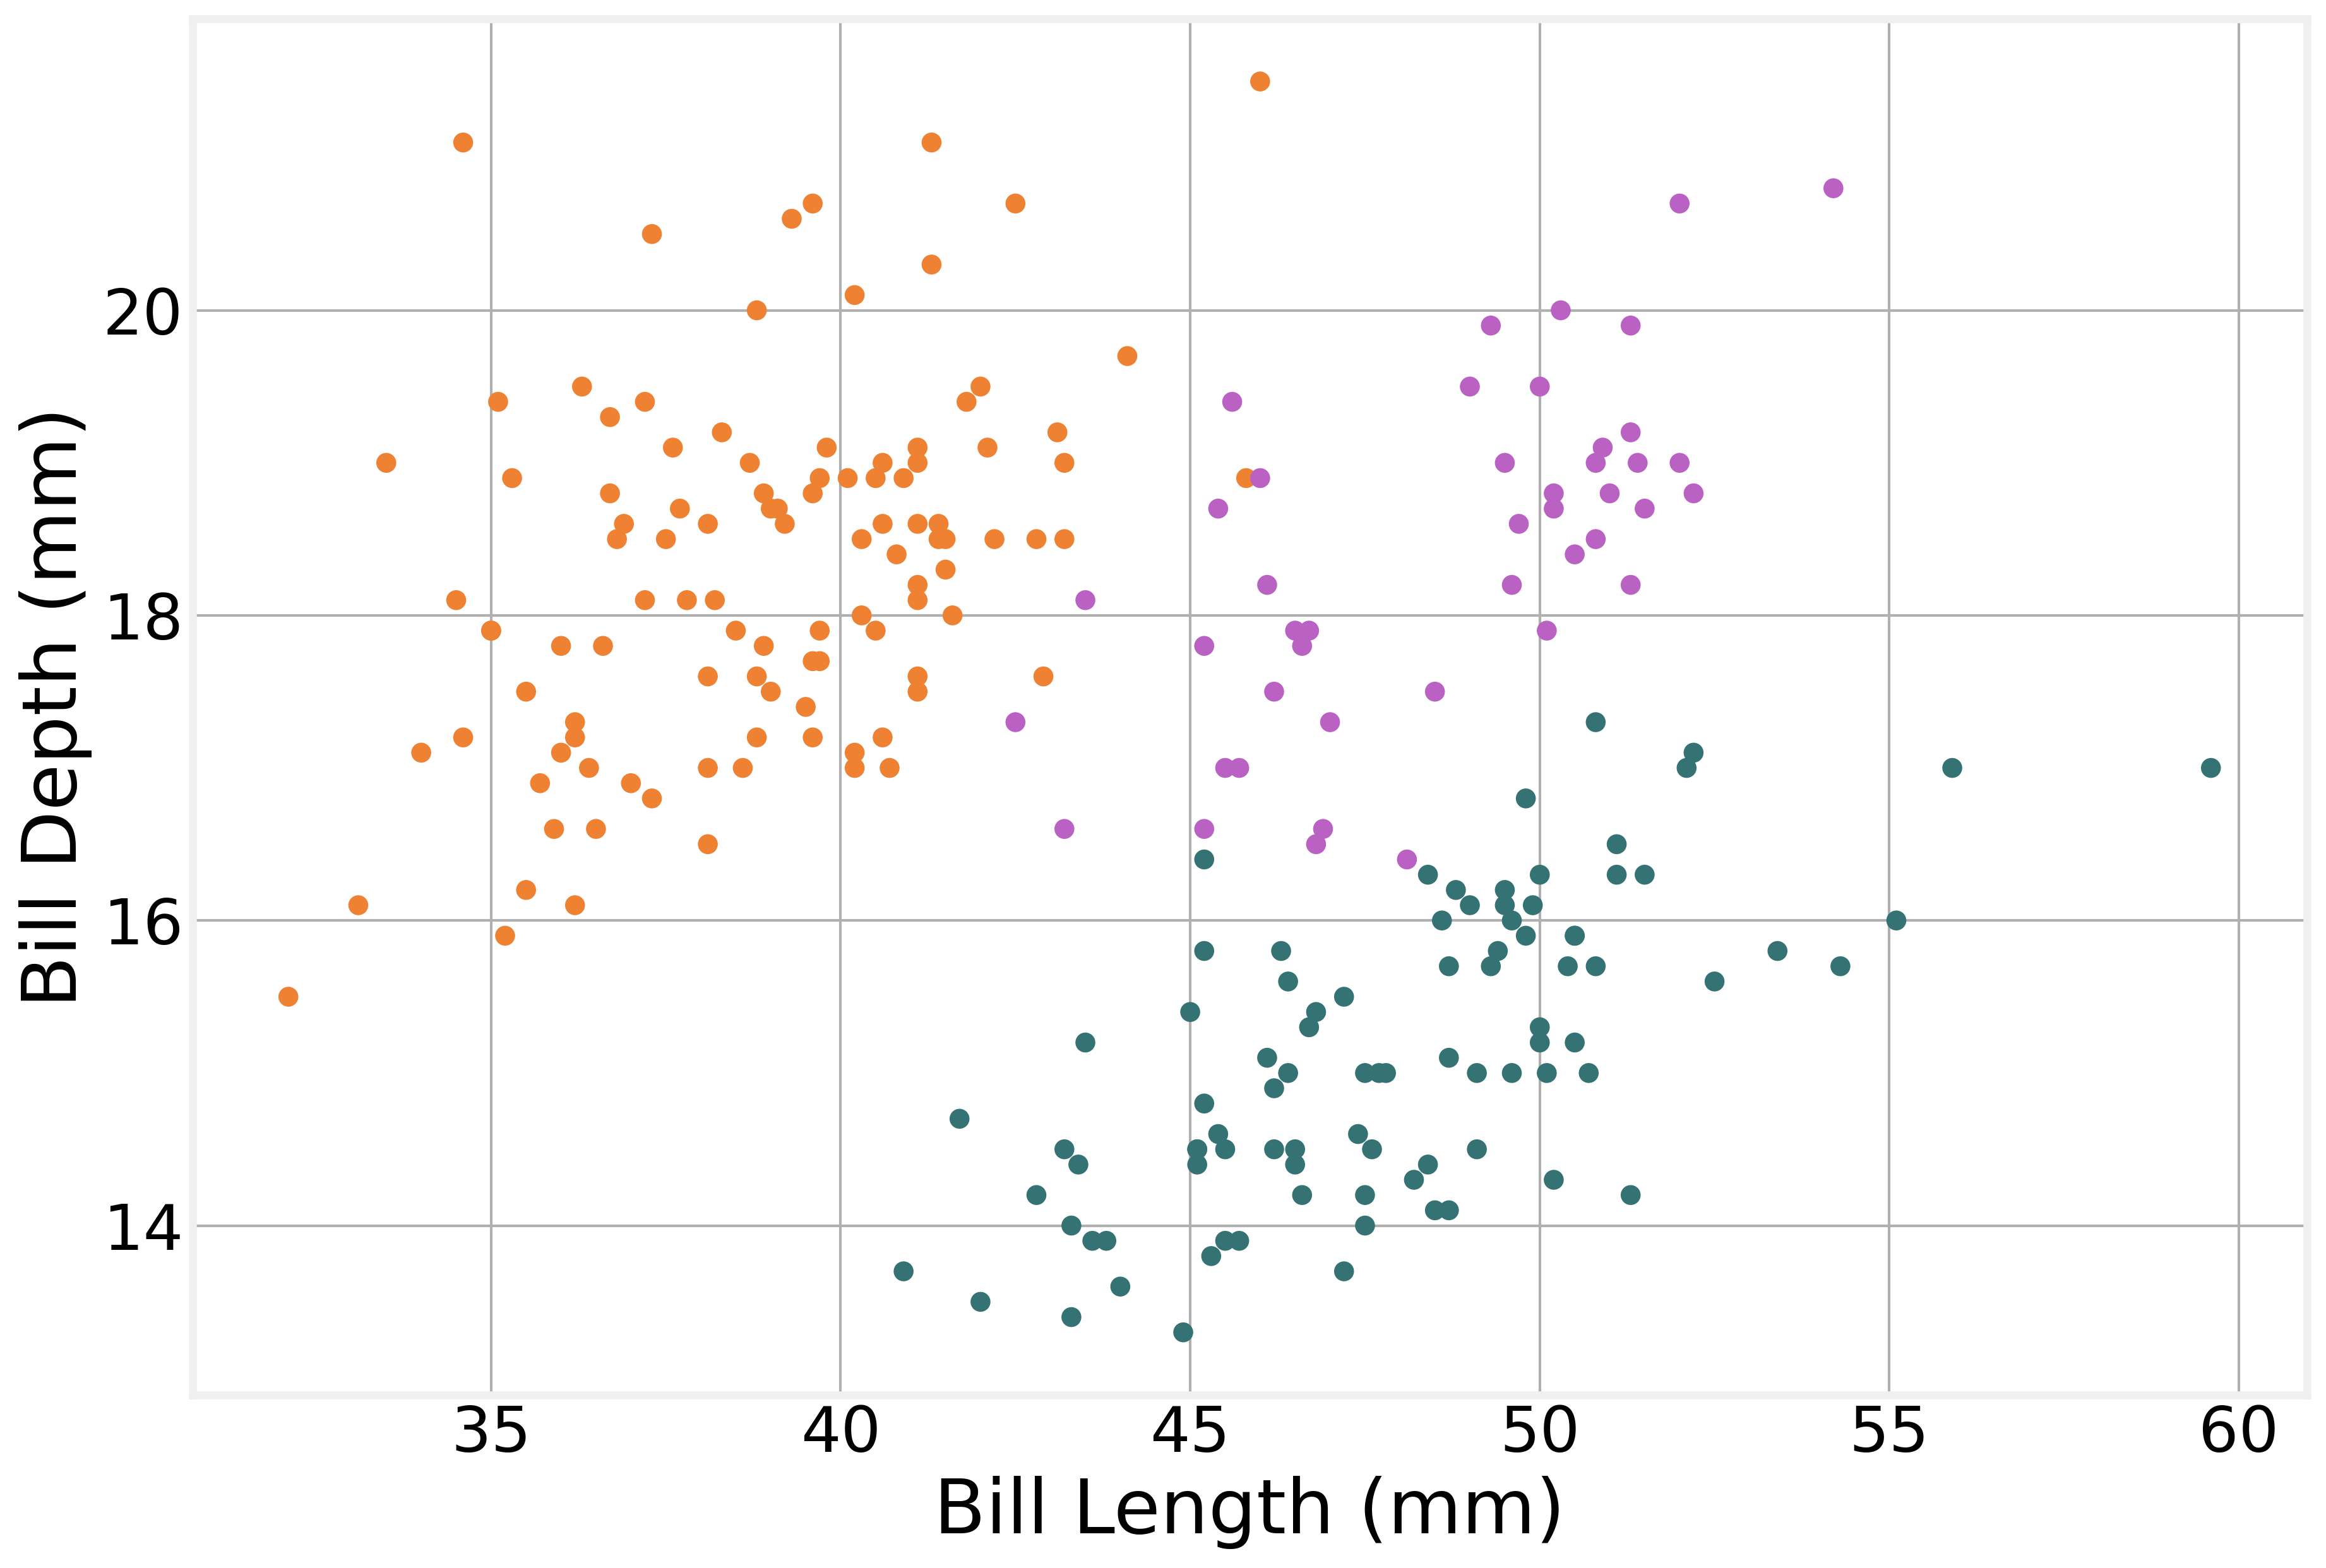

In [20]:
ax = X_train.plot.scatter(
                    x="bill_length_mm", 
                    y="bill_depth_mm", 
                    c=np.array(penguin_colors)[y_train],
                    s=50, 
                    )
ax.set_xlabel('Bill Length (mm)')
ax.set_ylabel('Bill Depth (mm)')
# ax.legend(
#     handles=[plt.Line2D([0], [0], marker='o', color='w', label=label, 
#                         markerfacecolor=color, markersize=10) for label, color in zip(penguins.species.cat.categories, penguin_colors)],
# )

In [21]:
def knn(x_train, y_train, x_test, k=3):
    """
    Implements the K-Nearest Neighbors algorithm using PyTorch.
    
    Parameters:
    x_train (torch.Tensor): Training data features.
    y_train (torch.Tensor): Training data labels.
    x_test (torch.Tensor): Test data features.
    k (int): Number of neighbors to consider.
    
    Returns:
    torch.Tensor: Predicted labels for the test data.
    """
    # Calculate the L2 distance between each test point and all training points
    distances = torch.cdist(x_test, x_train)
    
    # Get the indices of the k nearest neighbors
    knn_indices = distances.topk(k, largest=False).indices
    
    # Gather the labels of the k nearest neighbors
    knn_labels = y_train[knn_indices]
    
    # Predict the label by majority vote
    y_pred, _ = torch.mode(knn_labels, dim=1)
    
    return y_pred

In [22]:
y_ = knn(torch.Tensor(X_train.values), torch.Tensor(y_train), torch.Tensor(X_test.values), k=3)
y_ = y_.numpy().astype('int')

Text(0, 0.5, 'Bill Depth (mm)')

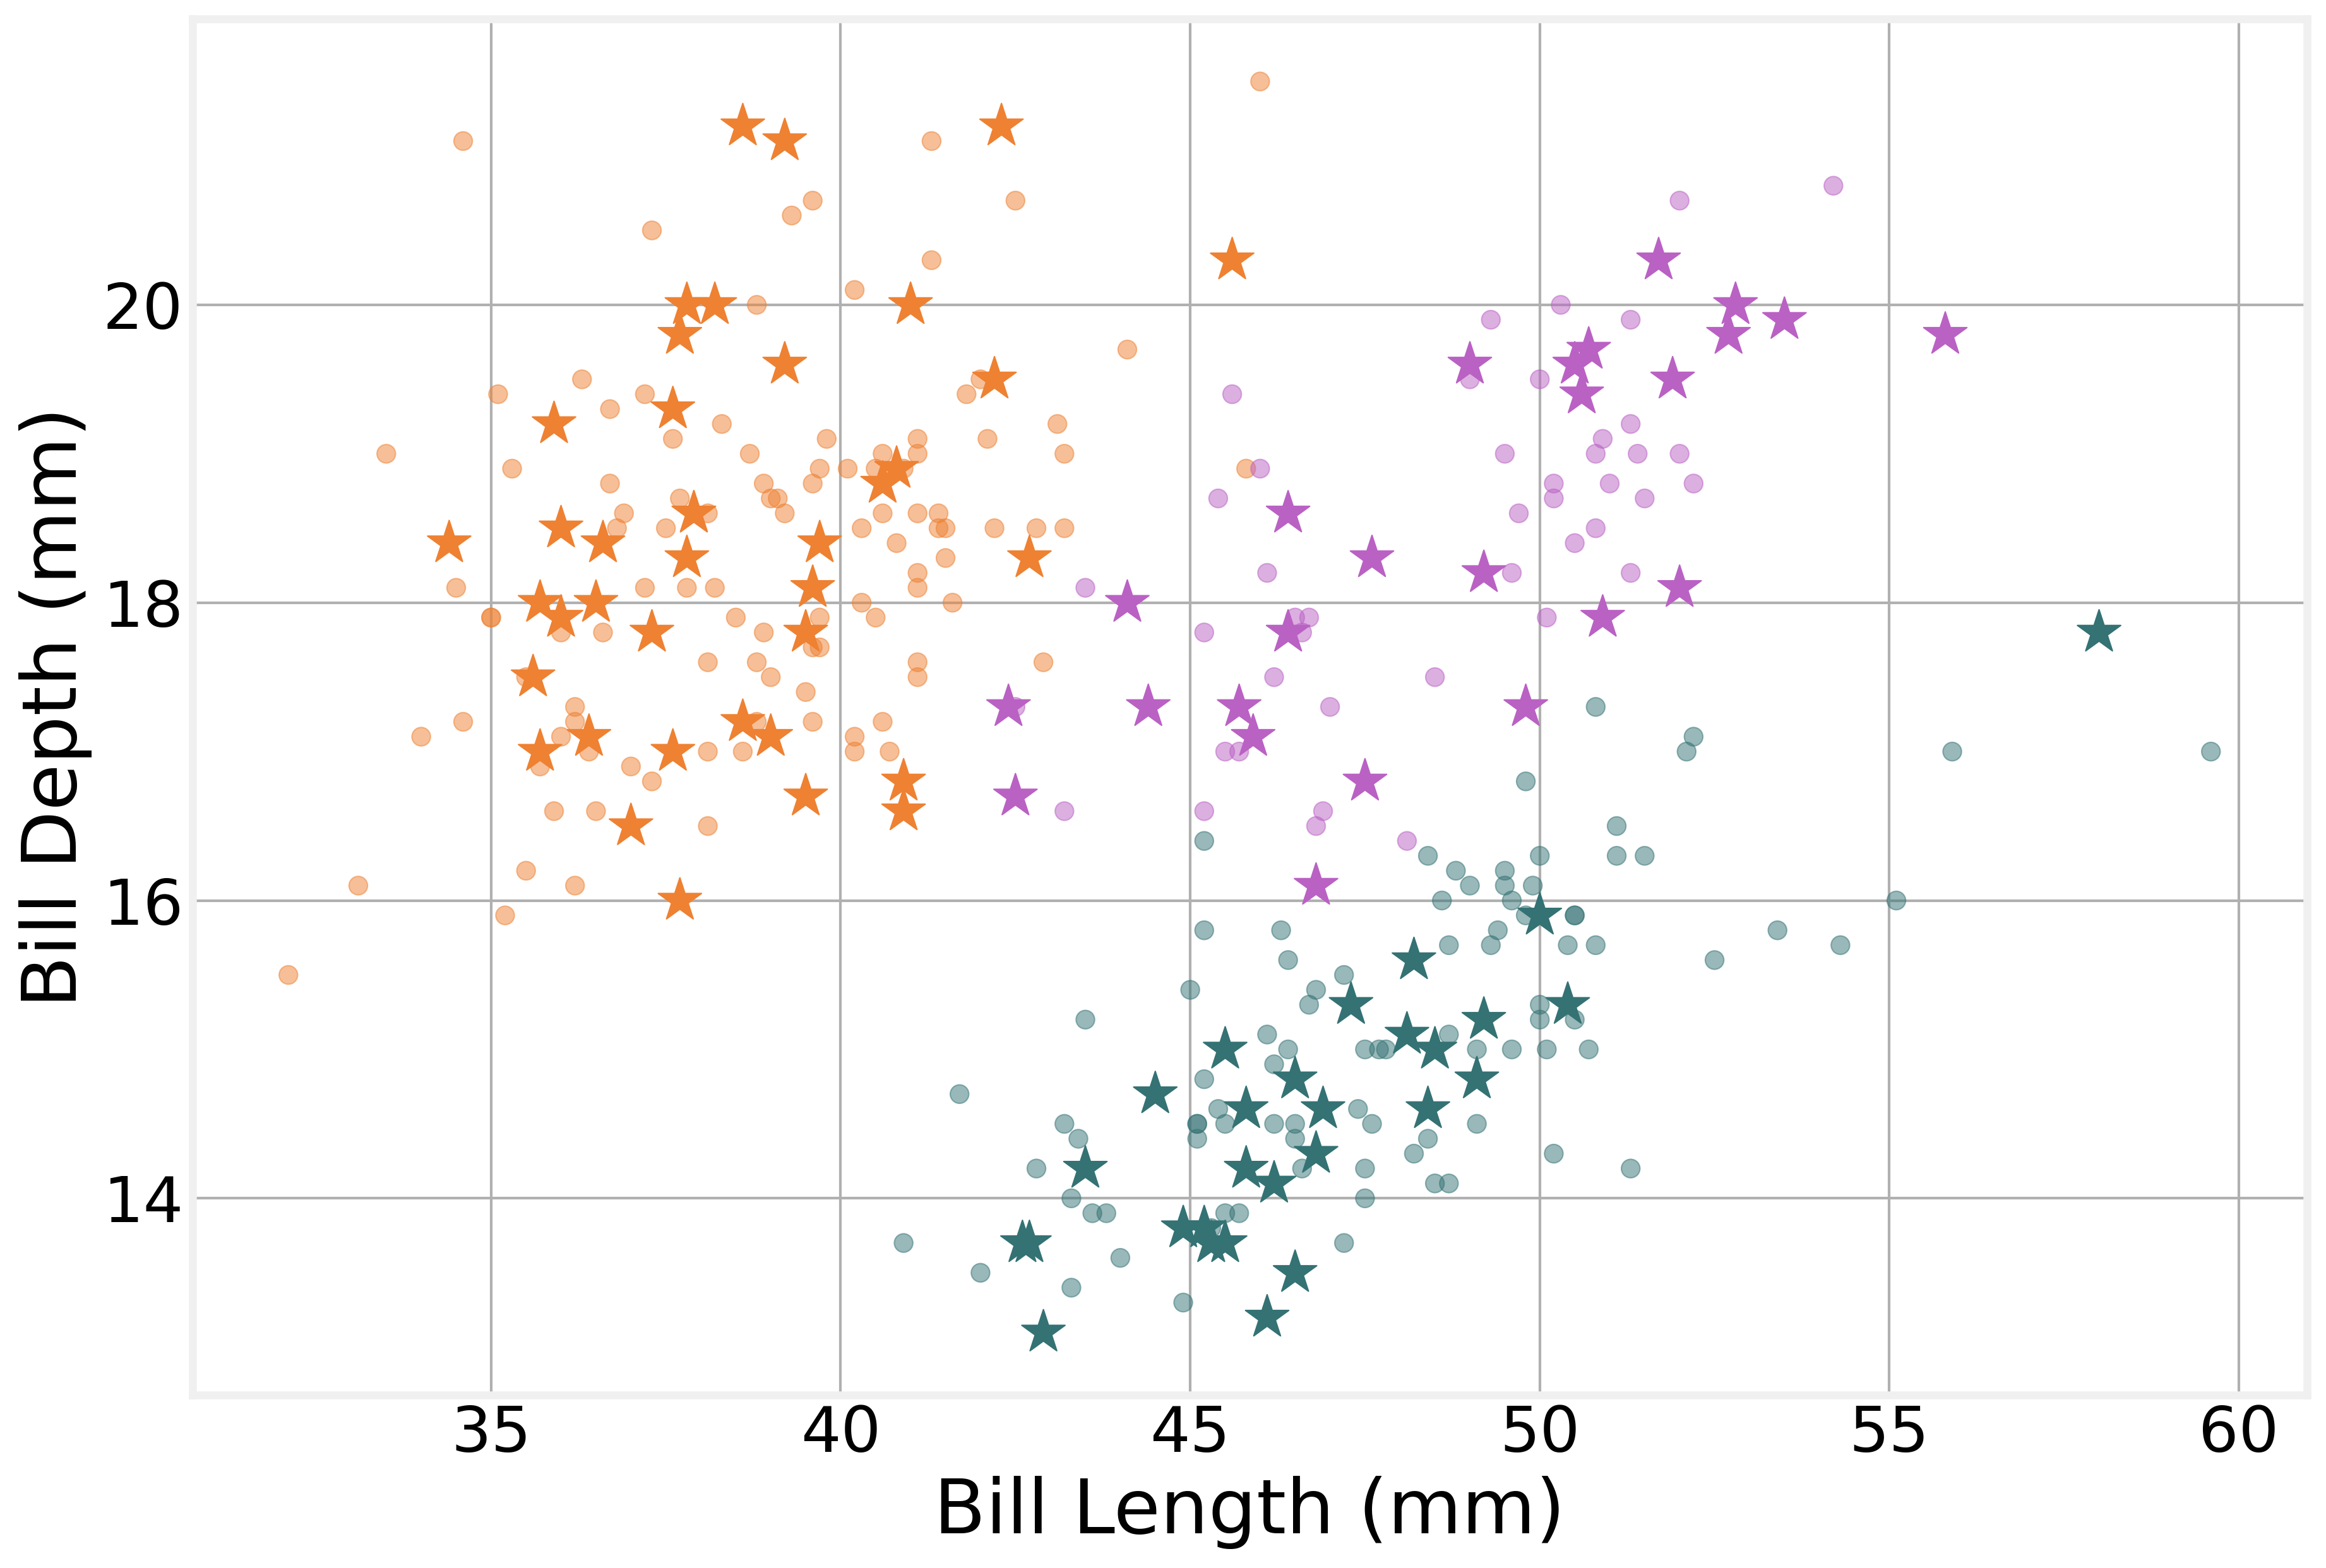

In [23]:
ax = X_train.plot.scatter(
                    x="bill_length_mm", 
                    y="bill_depth_mm", 
                    c=np.array(penguin_colors)[y_train],
                    s=50, 
                    alpha=0.5,
                    )
X_test.plot.scatter(
                    x="bill_length_mm", 
                    y="bill_depth_mm", 
                    c=np.array(penguin_colors)[y_],
                    s=300, 
                    marker='*',
                    ax=ax,
                    )
ax.set_xlabel('Bill Length (mm)')
ax.set_ylabel('Bill Depth (mm)')
# ax.legend(
#     handles=[plt.Line2D([0], [0], marker='o', color='w', label=label, 
#                         markerfacecolor=color, markersize=10) for label, color in zip(penguins.species.cat.categories, colors)],
# )

# Linear Regression

Load a small linear dataset

In [24]:
anscombe = np.loadtxt('data/Anscombe1.dat', delimiter=' ')
anscombe = torch.from_numpy(anscombe).float()

And extract our instances and labels

In [25]:
X = anscombe[:, 0].reshape(-1, 1)
y = anscombe[:, 1].reshape(-1, 1)

This has just a few points, but it's enough for our purposes

Text(0, 0.5, 'y')

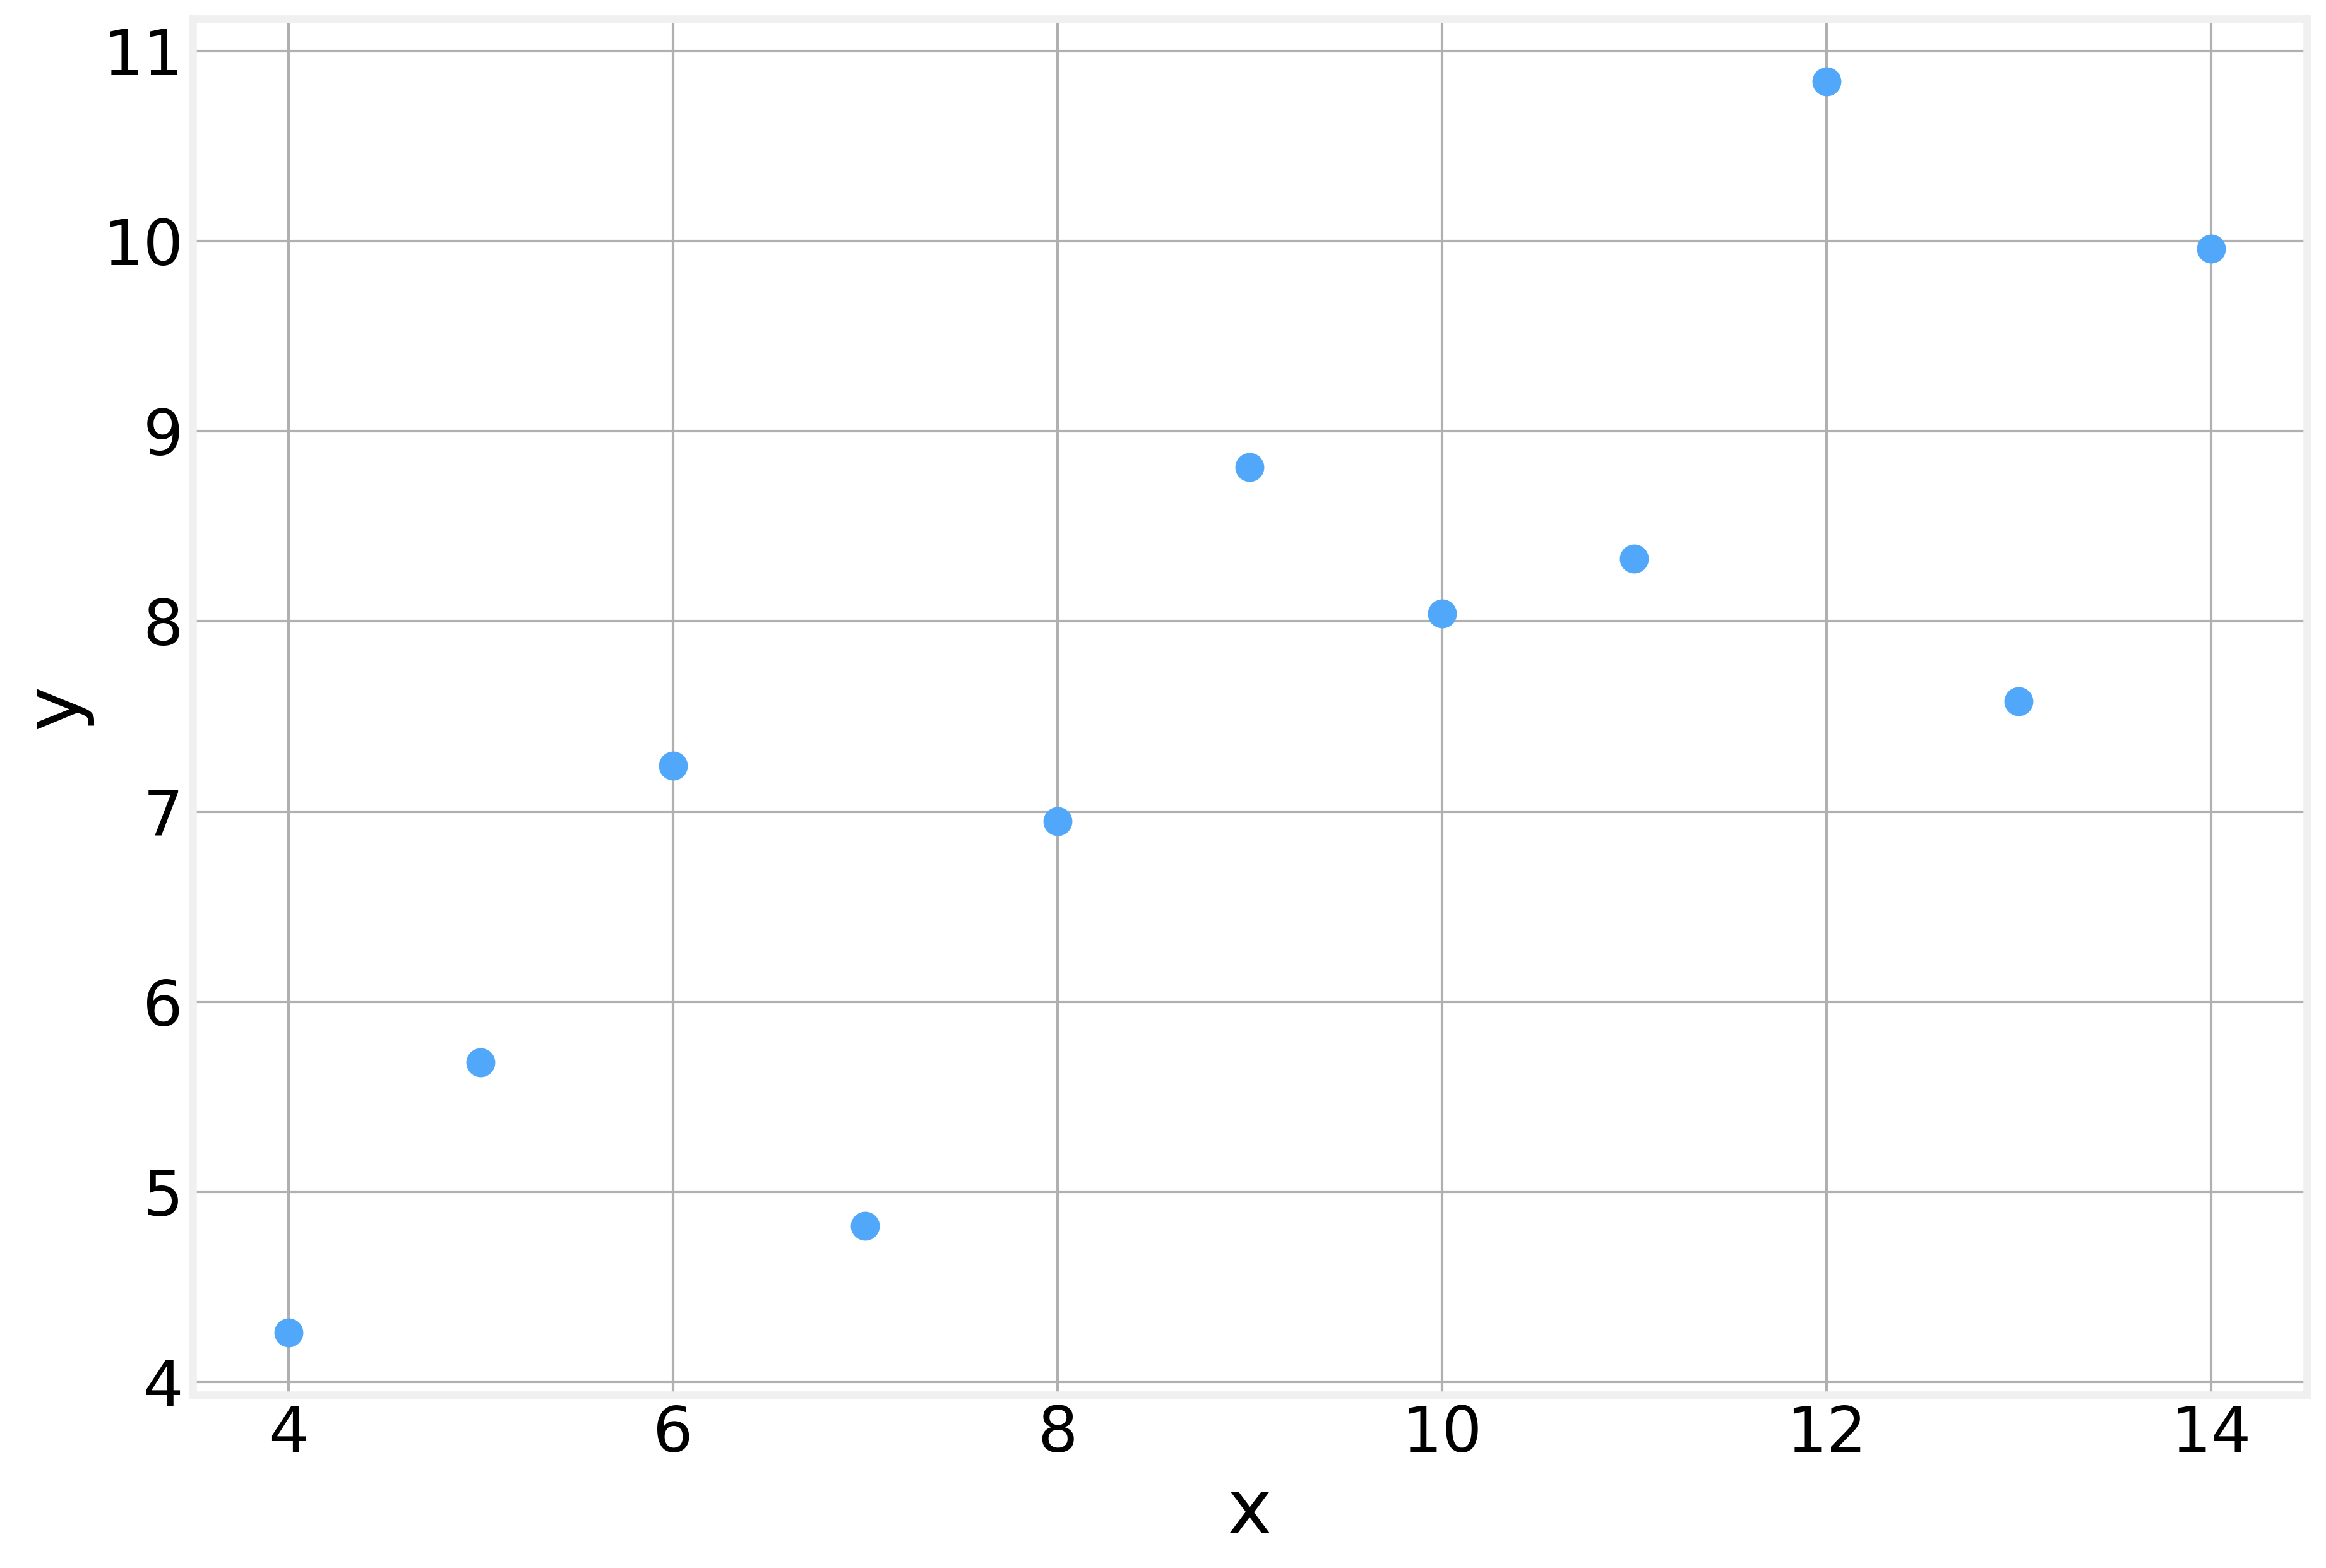

In [26]:
fig, ax = plt.subplots(1)
ax.plot(X, y, 
        marker='o', 
        markersize=10, 
        linestyle='None', 
        label='Data')
ax.set_xlabel('x')
ax.set_ylabel('y')

Now we can implement the linear regression procedure

In [27]:
def linear_regression(X, y, learning_rate=0.01, epochs=2000, verbose=False):
    # Add a column of ones to X to account for the bias term
    X = torch.cat([torch.ones(X.shape[0], 1), X], dim=1)
    
    # Initialize weights (including bias as the last weight)
    weights = torch.randn(X.shape[1], 1, requires_grad=True)
    
    for epoch in range(epochs):
        # Forward pass: compute predicted y
        y_pred = X @ weights
        
        # Compute quadratic loss
        loss = ((y_pred - y) ** 2).mean()
        
        # Backward pass: compute gradient of the loss with respect to weights
        loss.backward()
        
        # Update weights
        with torch.no_grad():
            weights -= learning_rate * weights.grad
            
            # Zero the gradients after updating
            weights.grad.zero_()
    
        if verbose and epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

    return weights

In [28]:
weights = linear_regression(X, y)
weights.flatten()

tensor([2.9400, 0.5060], grad_fn=<ViewBackward0>)

Model predictions are given simply by multiplying the full input matrix by the weights

In [29]:
X_ = torch.cat([torch.ones(X.shape[0], 1), X], dim=1)
y_ = (X_  @ weights).flatten().detach()
y_

tensor([ 8.0004,  6.9883,  9.5185,  7.4944,  8.5065, 10.0246,  5.9762,  4.9641,
         9.0125,  6.4823,  5.4702])

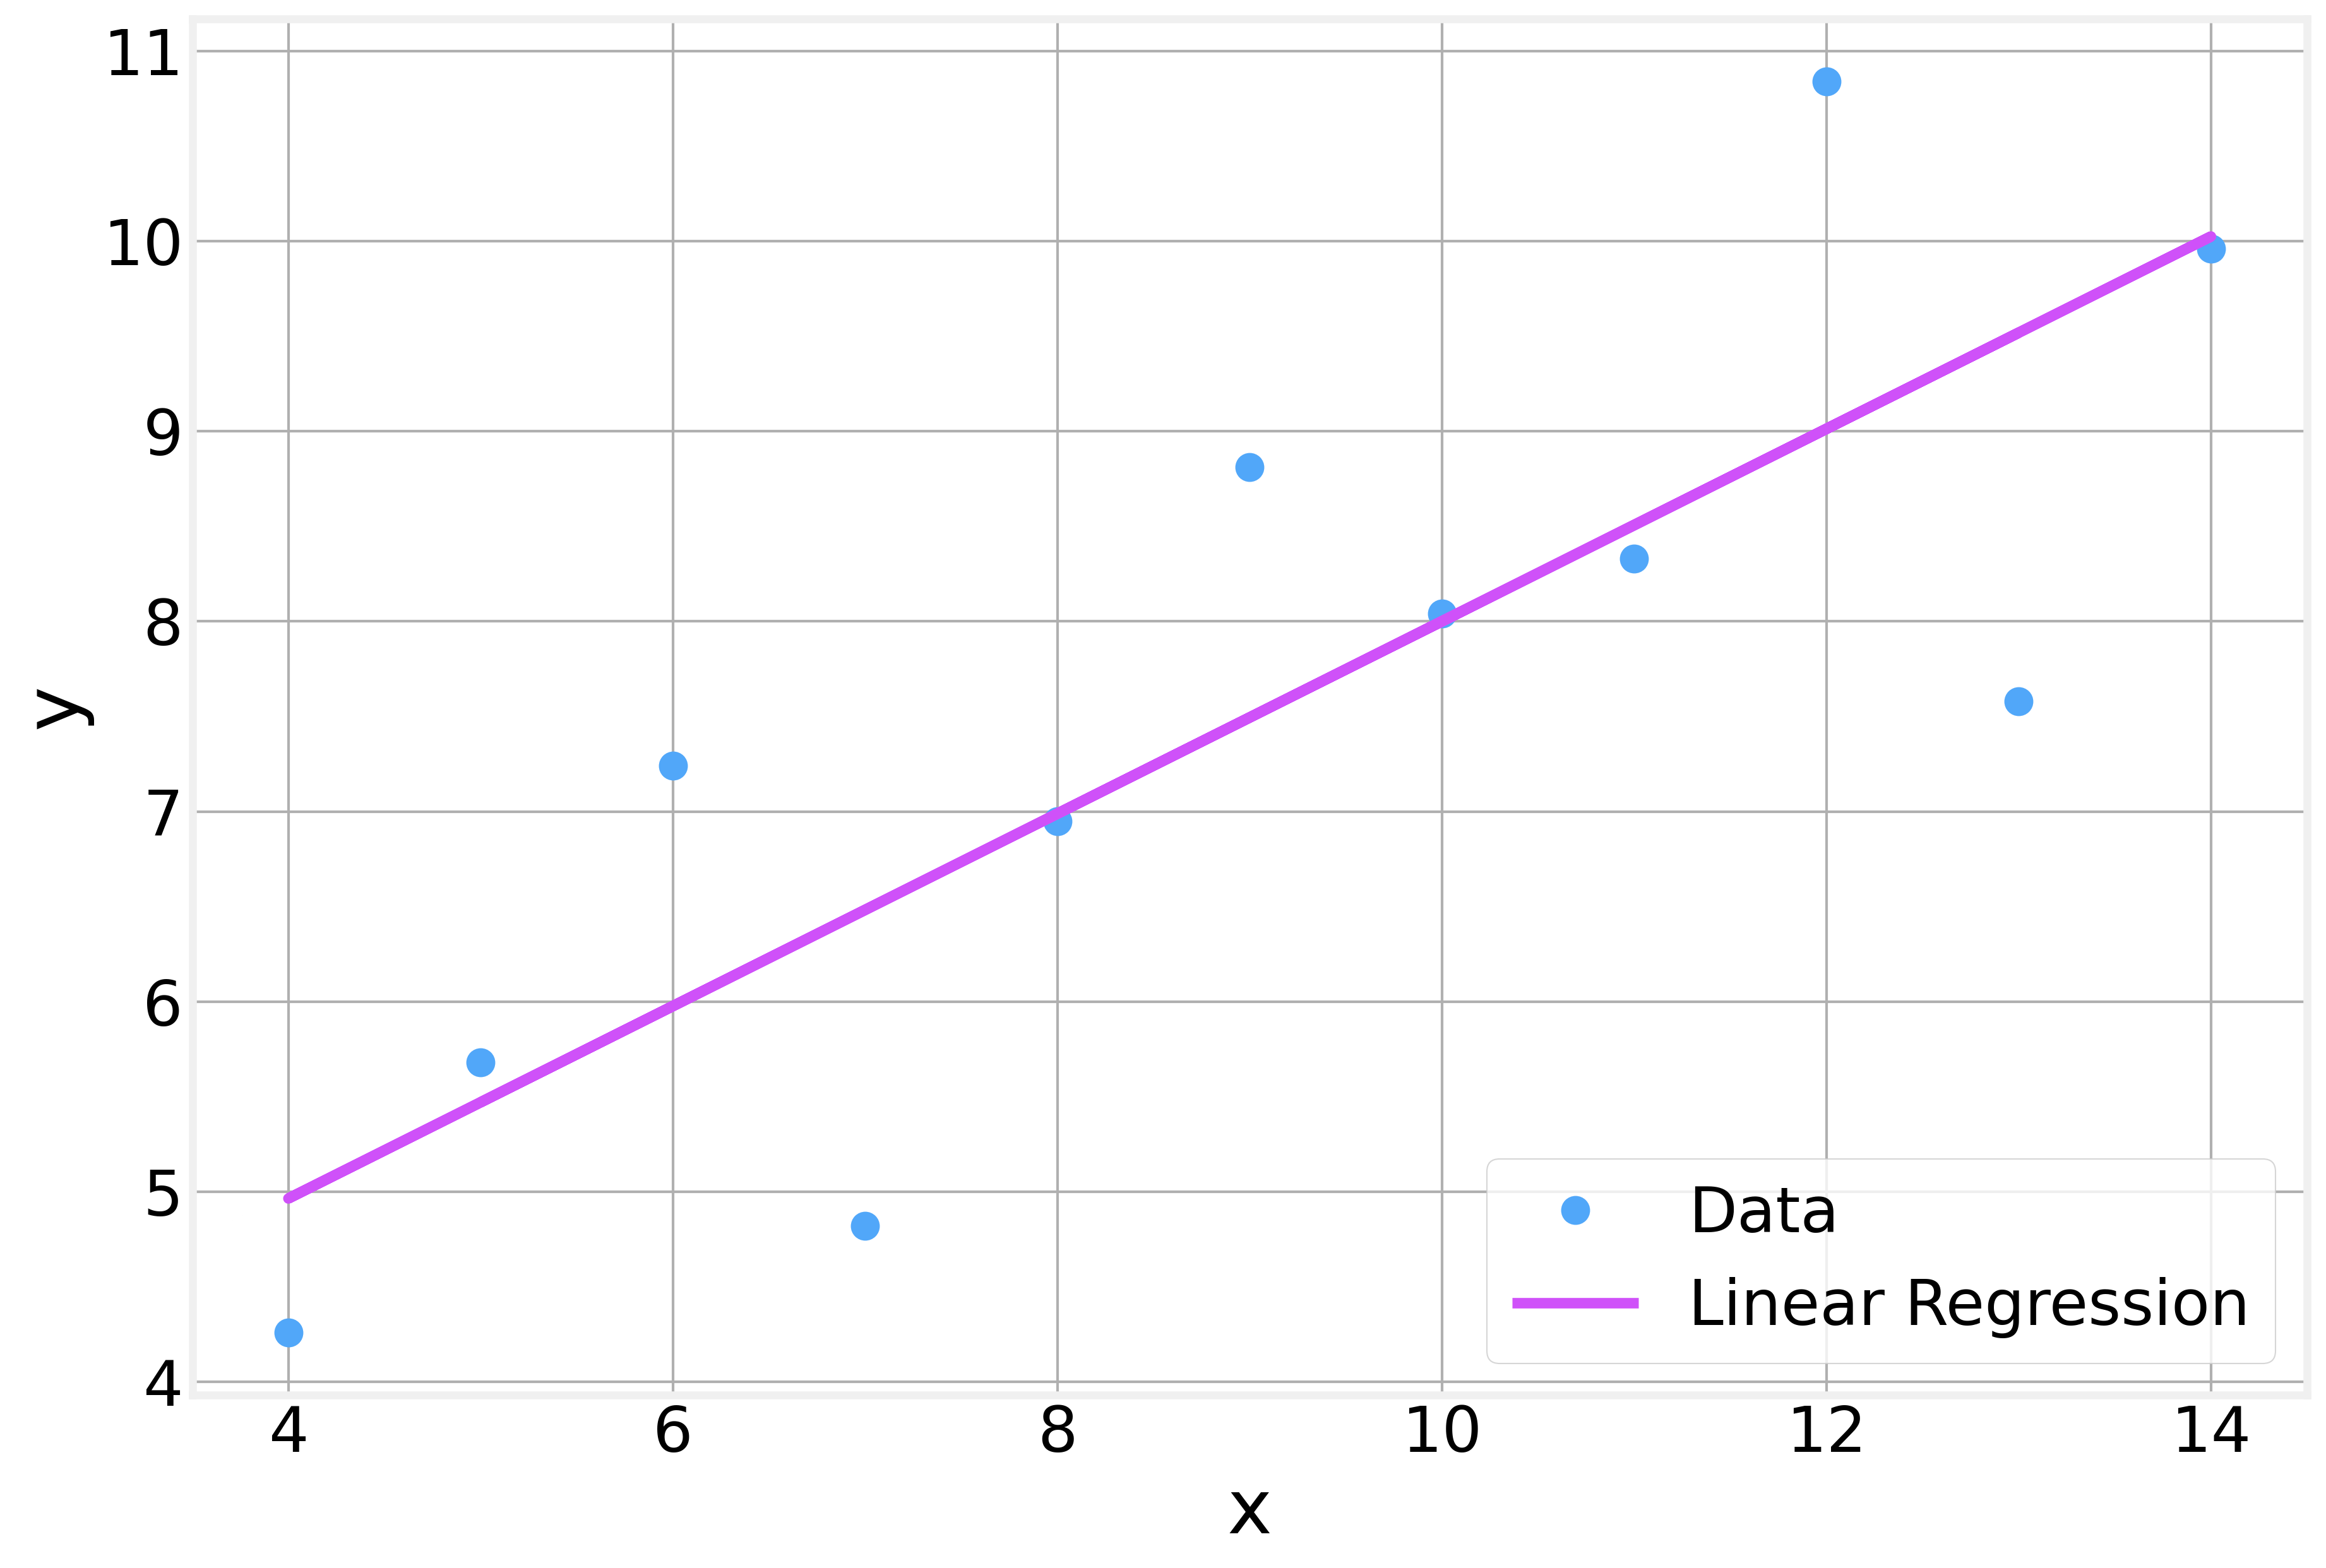

In [30]:
fig, ax = plt.subplots(1)
ax.plot(X, y, 
        marker='o', 
        markersize=10, 
        linestyle='None', 
        label='Data')
ax.plot(X, y_,
        linestyle='-', 
        label='Linear Regression')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(loc='lower right')

# Logistic Regression

In [31]:
iris = pd.read_csv('data/iris.csv')
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


Make the species categorical and add a numerical label column

In [32]:
iris.species = iris.species.astype('category')
iris['labels'] = iris.species.cat.codes

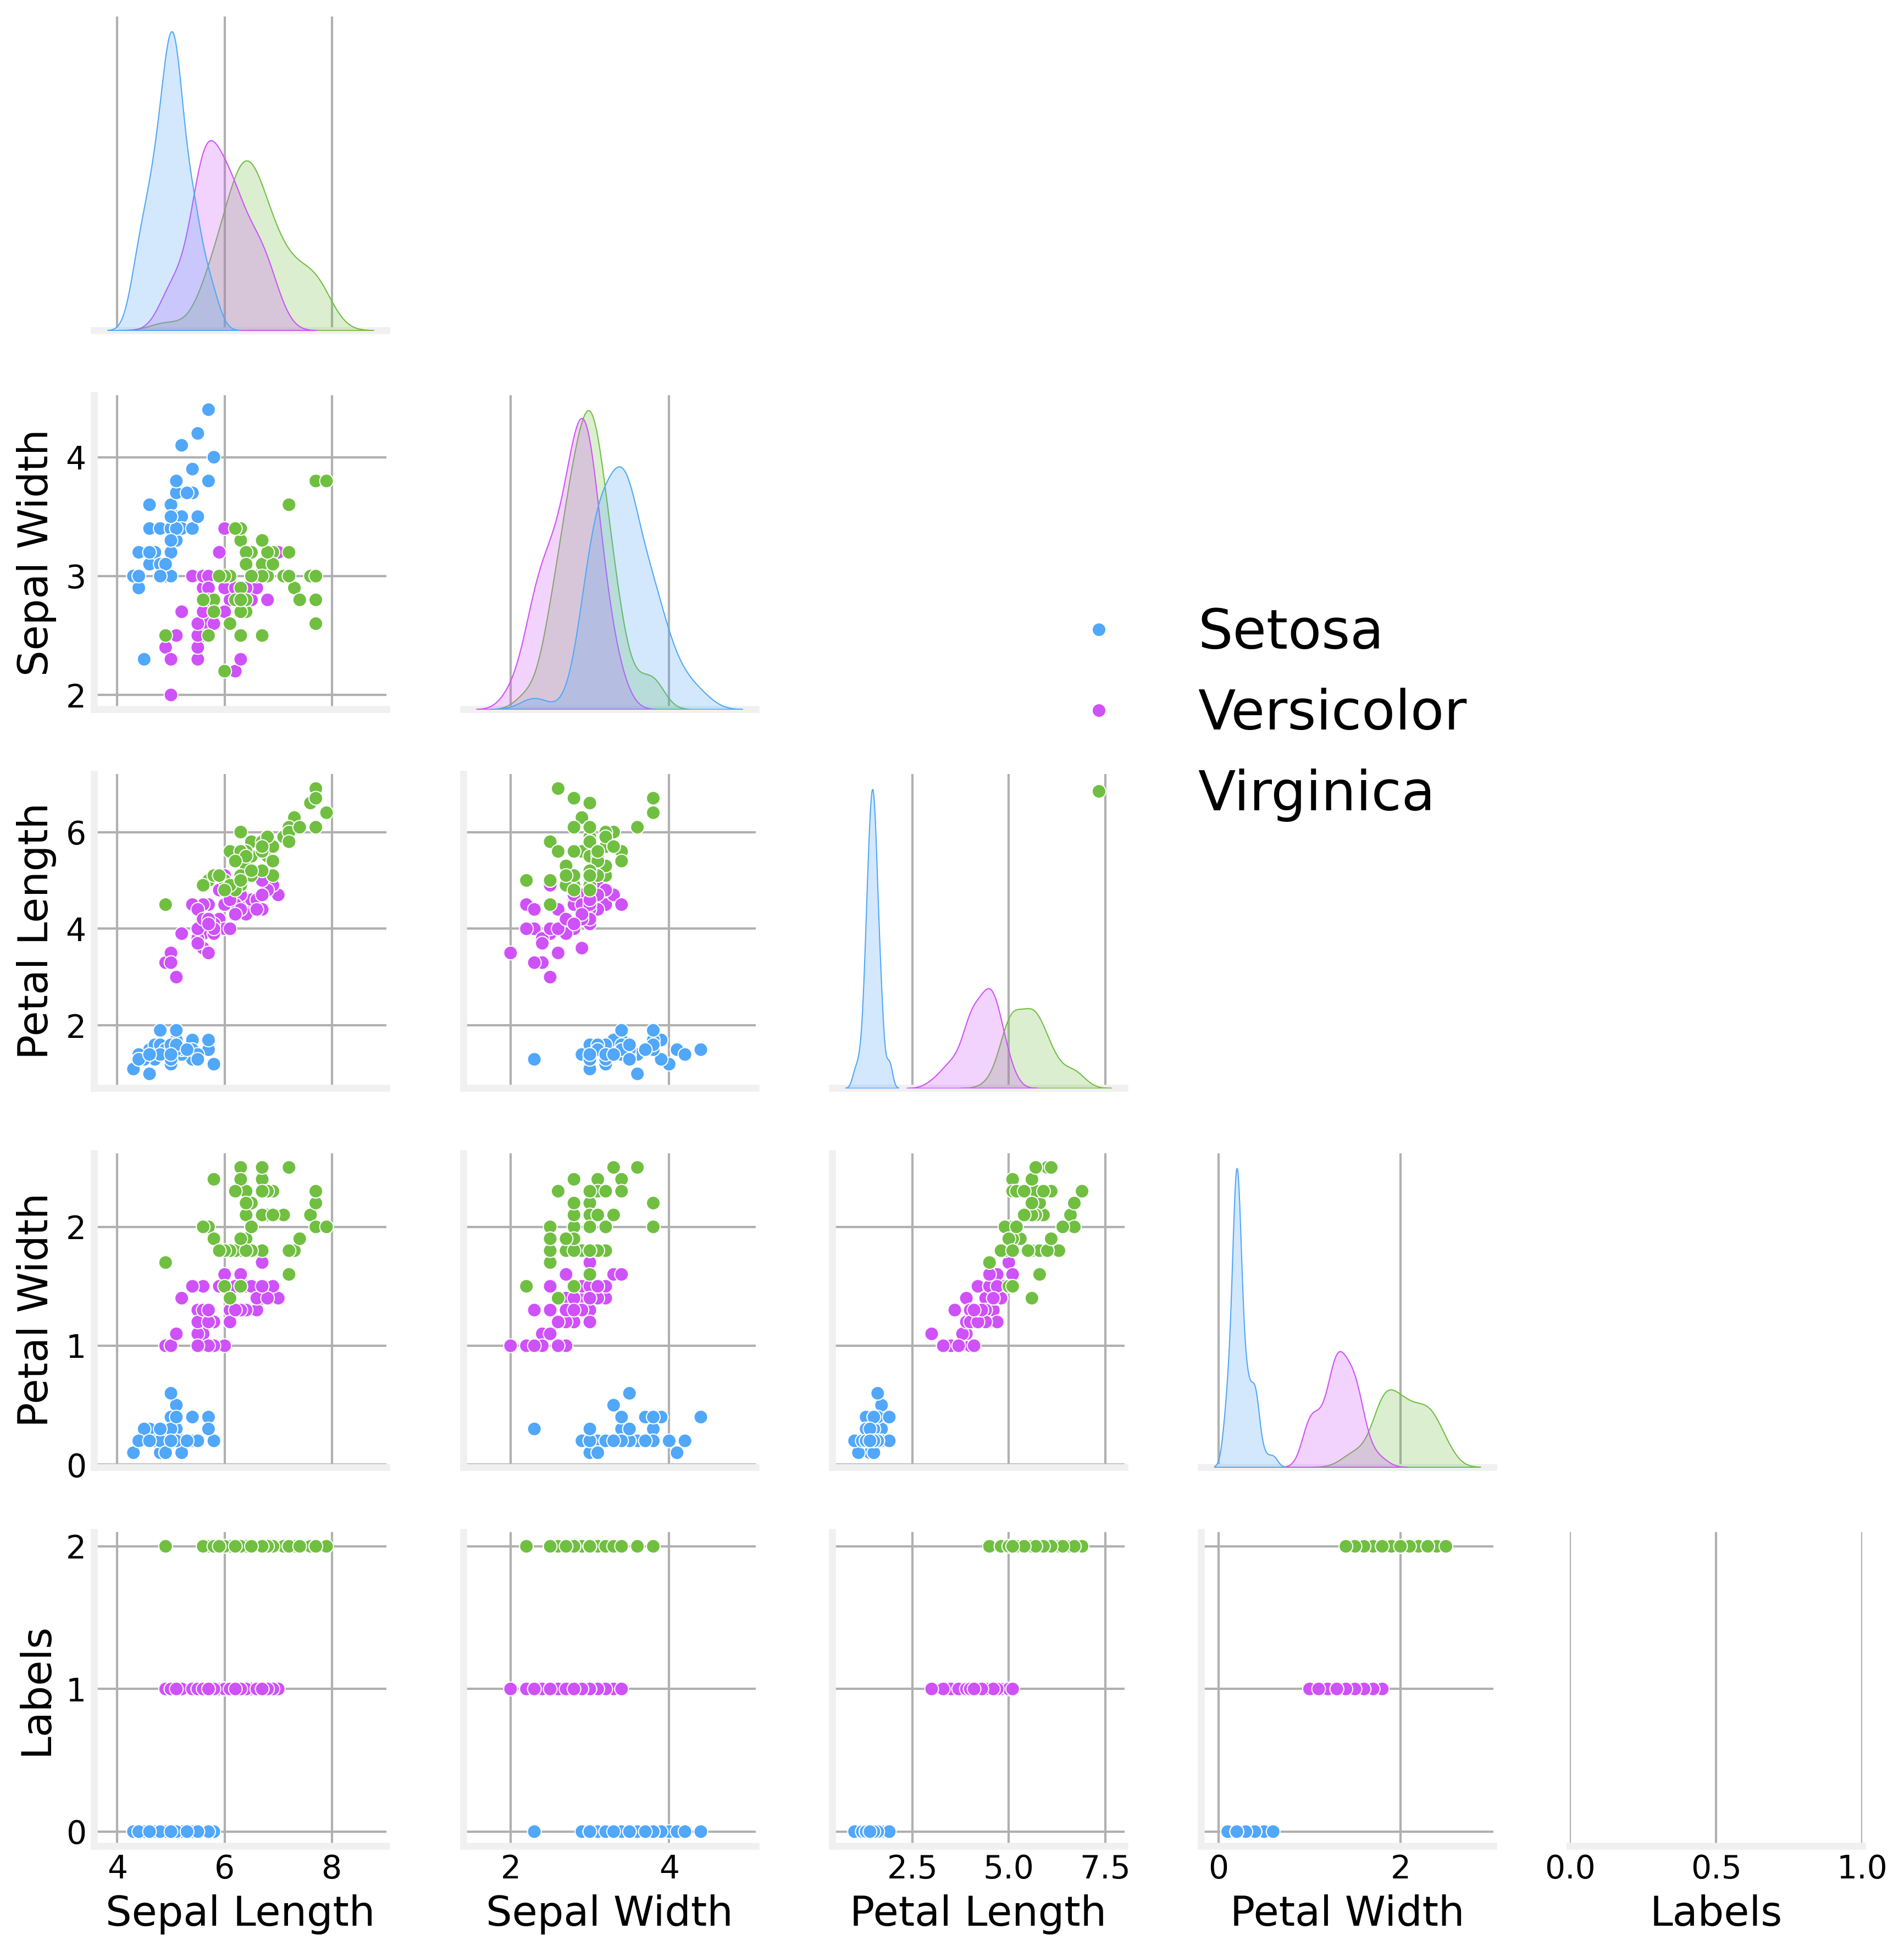

In [33]:
pp = sns.pairplot(iris, hue='species', corner=True)
for ax in pp.axes.flatten():
    if ax is not None:
        ax.set(xlabel=" ".join(ax.get_xlabel().split('_')).title(), 
               ylabel=" ".join(ax.get_ylabel().split('_')).title(),
               )
        ax.tick_params(axis='both', which='major', labelsize=14)
        ax.xaxis.label.set_size(18)
        ax.yaxis.label.set_size(18)

# pp.add_legend()
pp._legend.set_bbox_to_anchor((0.6, 0.6))
pp._legend.set_title(None)
for t, l in zip(pp._legend.texts, iris['species'].unique()):
    t.set_text(l.title())

Let us focus on a specific pair of features

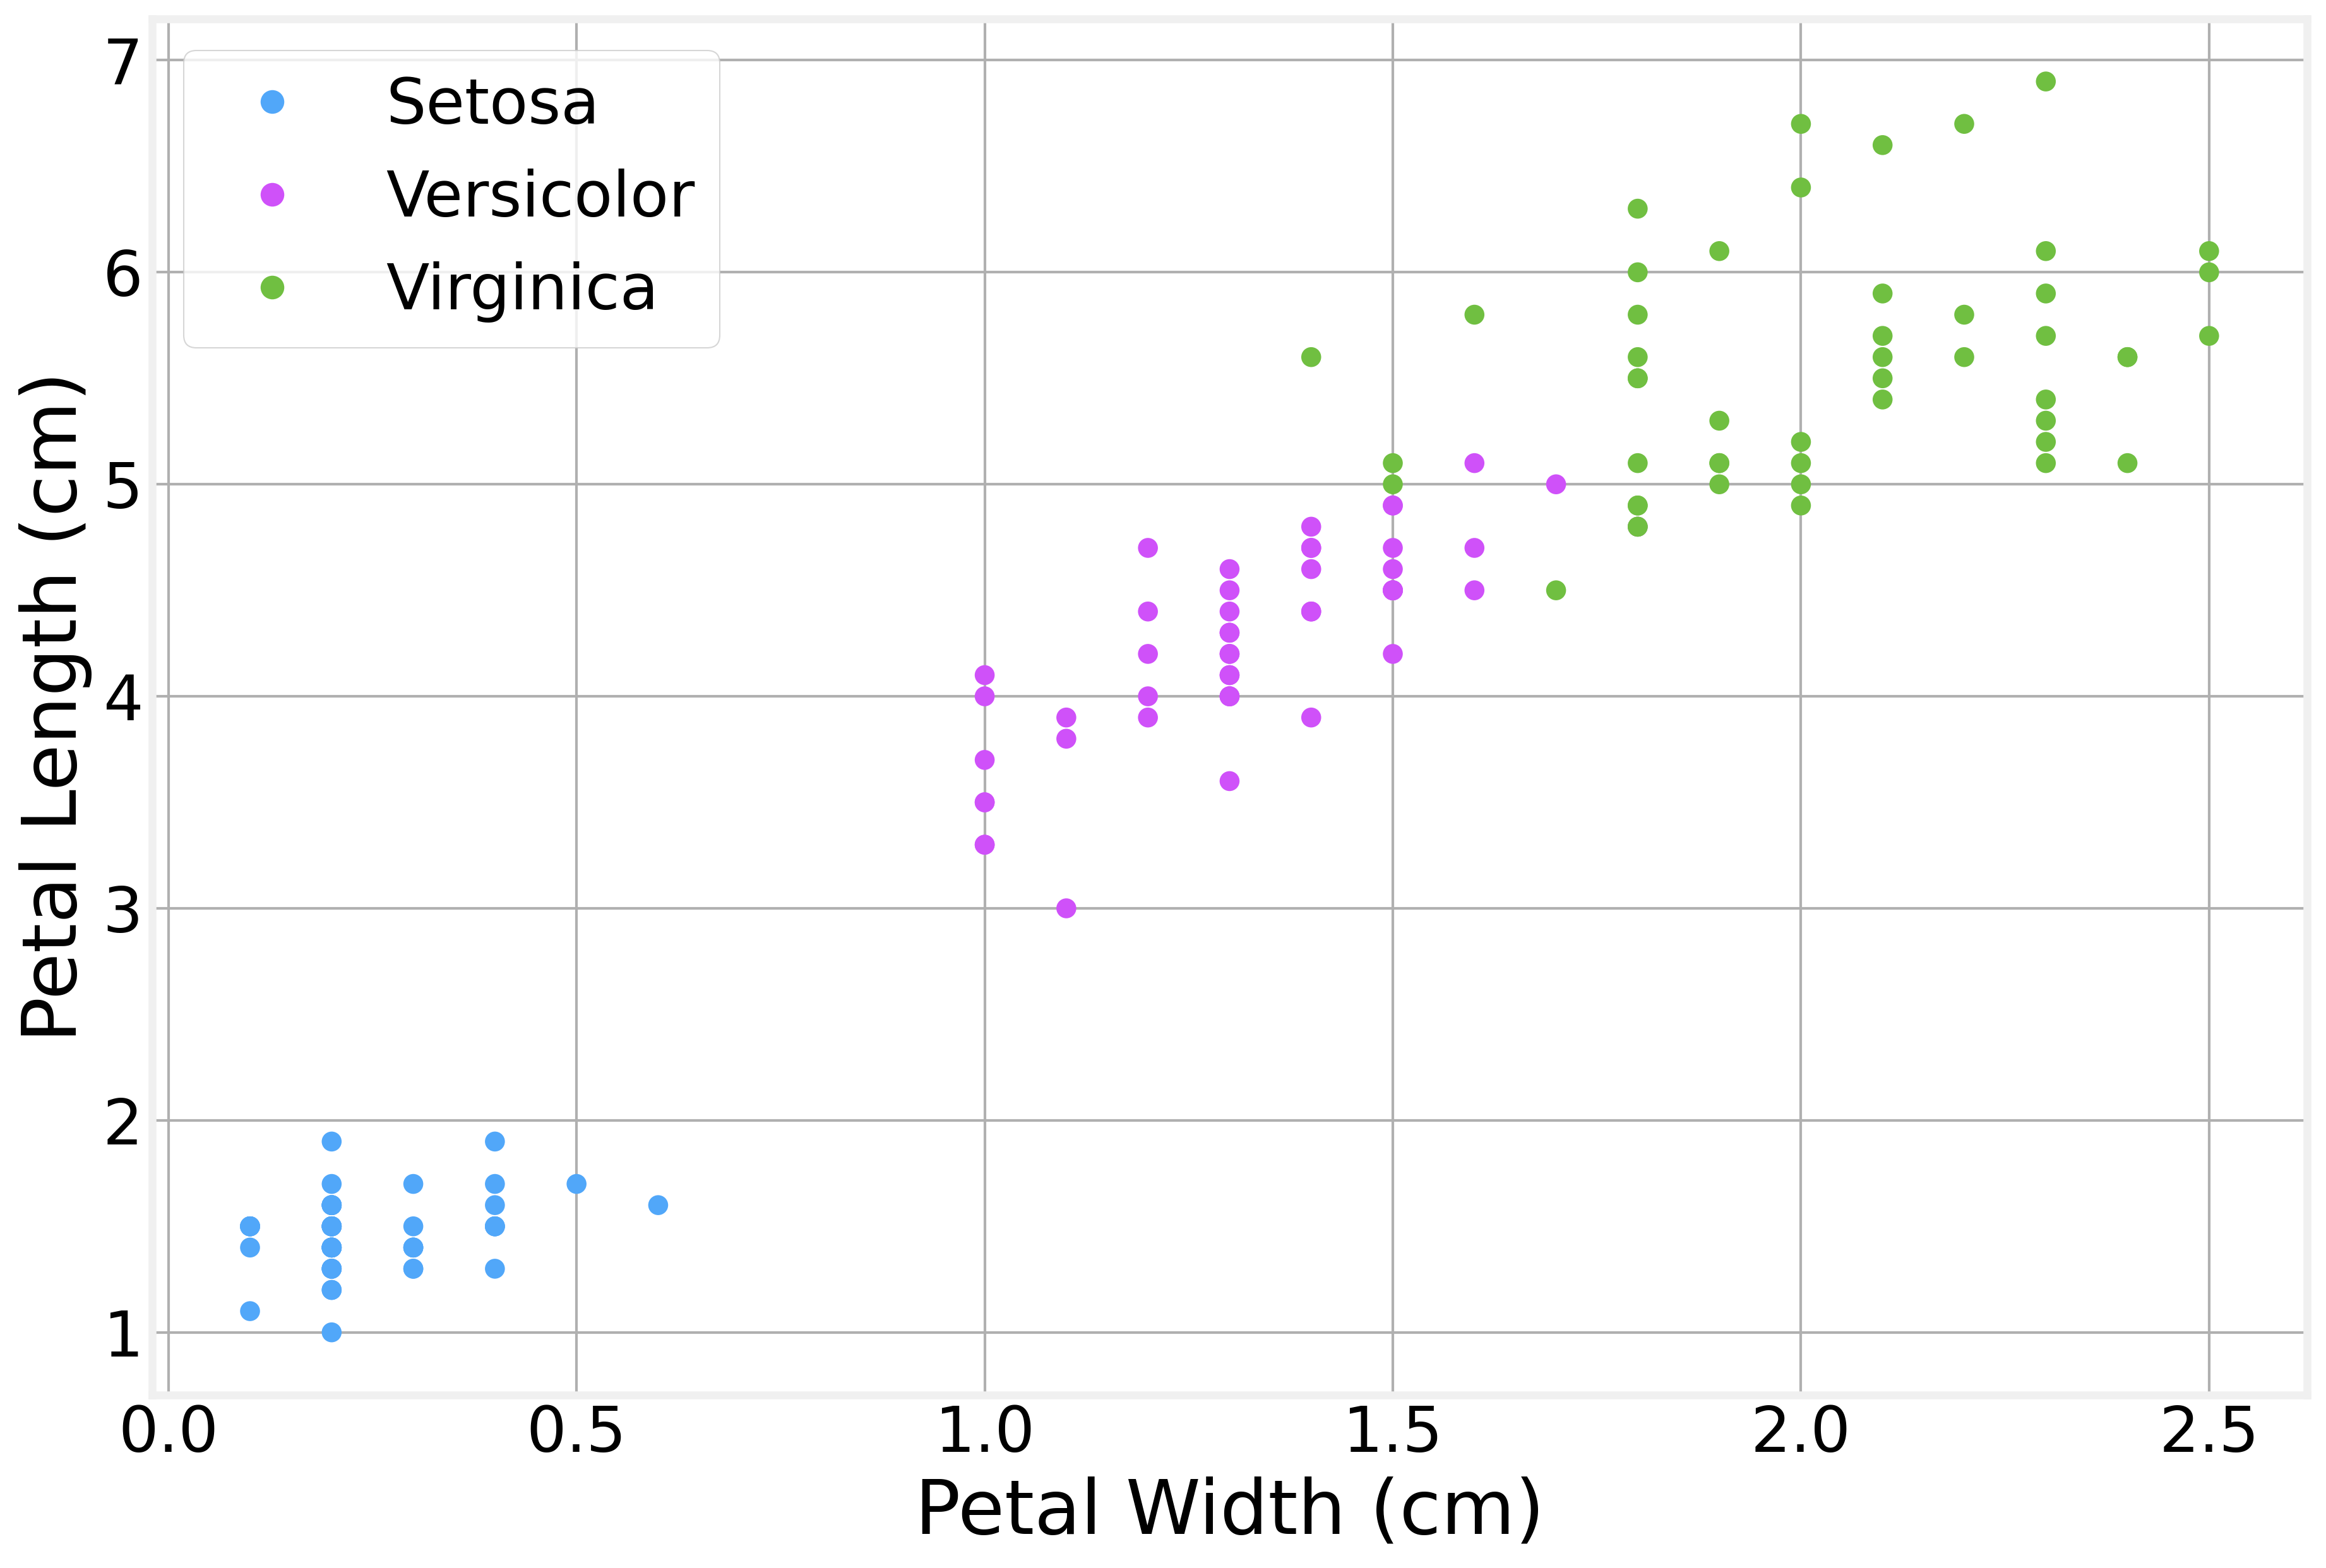

In [34]:
fig, ax = plt.subplots(1)
iris.plot.scatter(
        x='petal_width', 
        y='petal_length', 
        c=np.array(colors)[iris.labels], 
        s=50,
        ax=ax)
ax.set_xlabel('Petal Width (cm)')
ax.set_ylabel('Petal Length (cm)')

handles = [plt.Line2D([0], [0], marker='o', color='w', label=label.title(), 
                                          markerfacecolor=color, markersize=10) 
                   for label, color in zip(iris.species.cat.categories, colors[:3])]
ax.legend(handles=handles)


We'll try to classify every instance between Virginica and not Virginica

In [35]:
iris['y'] = (iris['labels'] == 2).astype('int')
iris_colors = np.array([colors[5], colors[2]])

In [36]:
iris.labels.unique()

array([0, 1, 2], dtype=int8)

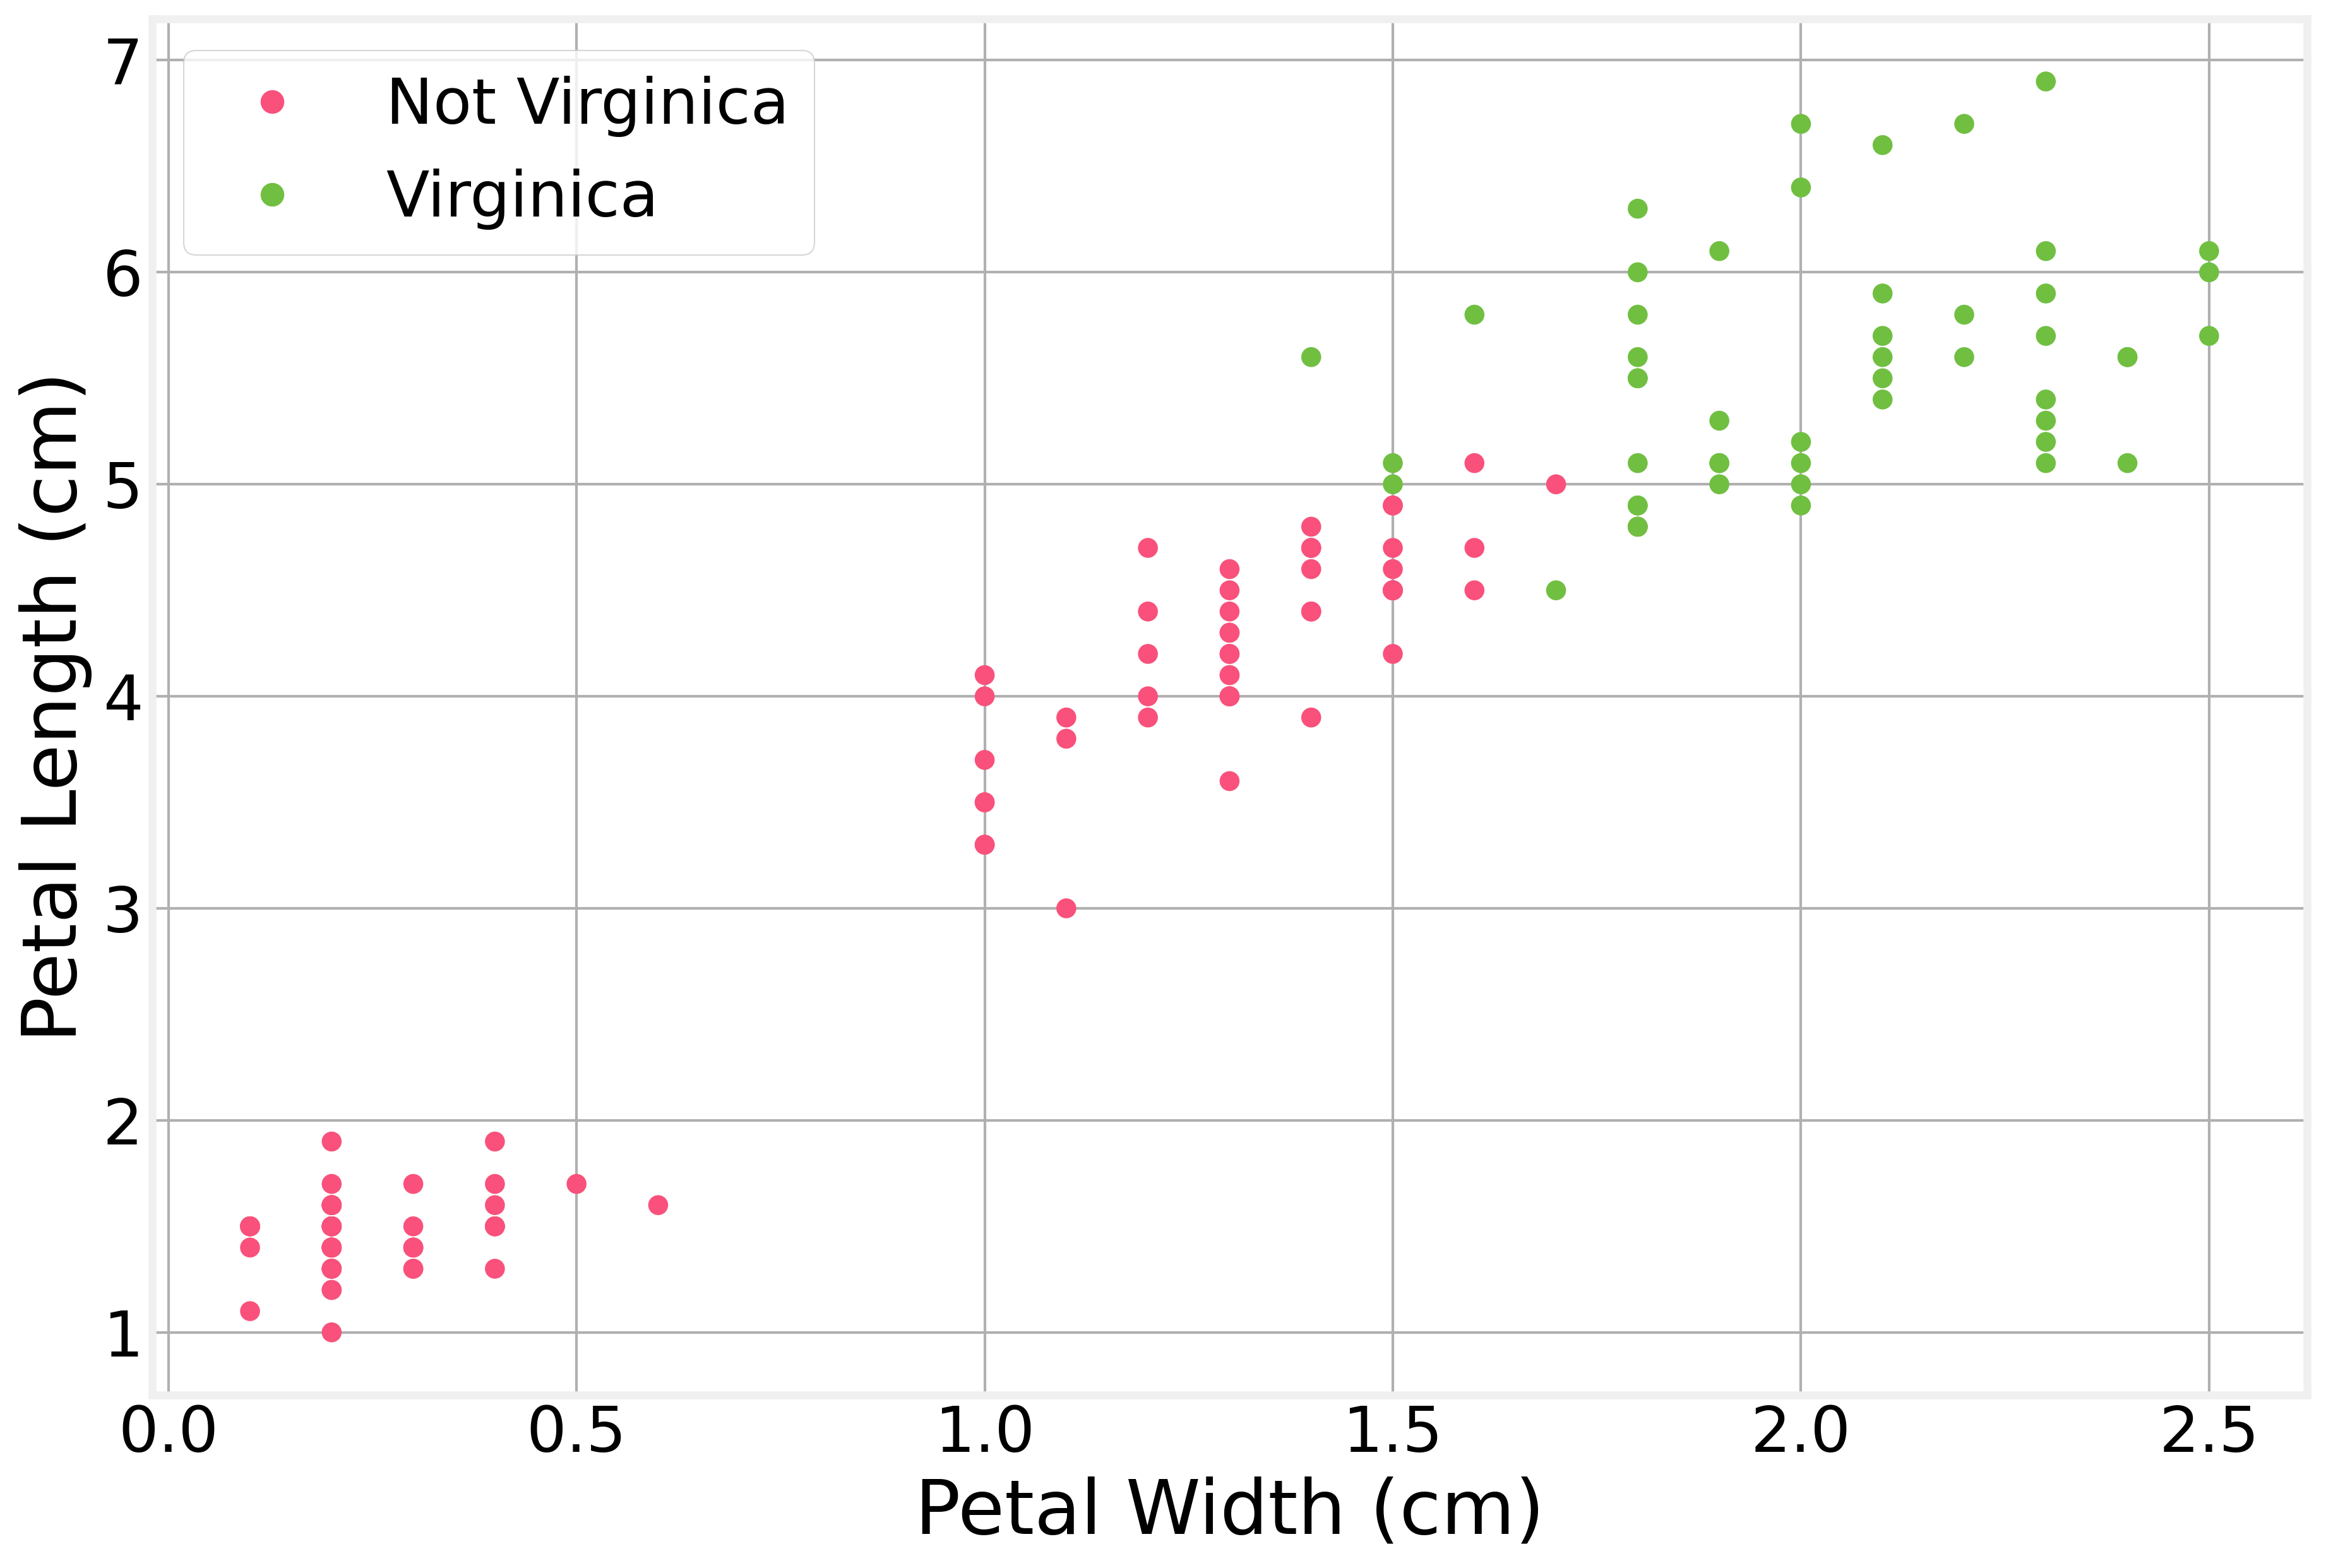

In [37]:
fig, ax = plt.subplots(1)
iris.plot.scatter(
        x='petal_width', 
        y='petal_length', 
        c=iris_colors[iris['y']], 
        s=50,
        ax=ax)
ax.set_xlabel('Petal Width (cm)')
ax.set_ylabel('Petal Length (cm)')

handles = [plt.Line2D([0], [0], marker='o', color='w', label=label.title(), 
                                          markerfacecolor=color, markersize=10) 
                   for label, color in zip(['Not Virginica', 'Virginica'],iris_colors)]
ax.legend(handles=handles)


Now we implement Logistic Regression

In [38]:
def logistic_regression(X, y, learning_rate=0.01, epochs=2000, verbose=False):
    # Add a column of ones to X to account for the bias term
    X = torch.cat([torch.ones(X.shape[0], 1), X], dim=1)

    # Initialize weights and bias
    weights = torch.randn(X.shape[1], 1, requires_grad=True)

    for epoch in range(epochs):
        # Forward pass: compute predicted y
        z = X @ weights
        
        # Sigmoid function
        predictions = torch.sigmoid(z)
        
        # Loss function (Binary Cross-Entropy)
        loss = -torch.mean(y * torch.log(predictions) + (1 - y) * torch.log(1 - predictions))
        
        # Backpropagation
        loss.backward()
        
        # Update weights and bias
        with torch.no_grad():
            weights -= learning_rate * weights.grad
            
            # Zero the gradients after updating
            weights.grad.zero_()
        
        if verbose and epoch % 100 == 0:
            print(f'Step {epoch}, Loss: {loss.item()}')
    
    return weights

In [39]:
X = torch.tensor(iris[['petal_width', 'petal_length']].values, dtype=torch.float32)
y = torch.tensor(iris['y'].values, dtype=torch.float32).reshape(-1, 1)
weights = logistic_regression(X, y)

In [40]:
weights

tensor([[-2.1082],
        [ 1.6482],
        [-0.1089]], requires_grad=True)

In [41]:
X_ = torch.cat([torch.ones(X.shape[0], 1), X], dim=1)
z = X_ @ weights
predictions = torch.sigmoid(z).detach()

In [42]:
def accuracy(predictions, y, threshold=0.5):
    return ((predictions > threshold) == y).float().mean().detach().numpy()

In [43]:
acc = np.array([accuracy(predictions, y, threshold=t) for t in np.linspace(0, 1, 100)])

Text(0, 0.5, 'Accuracy')

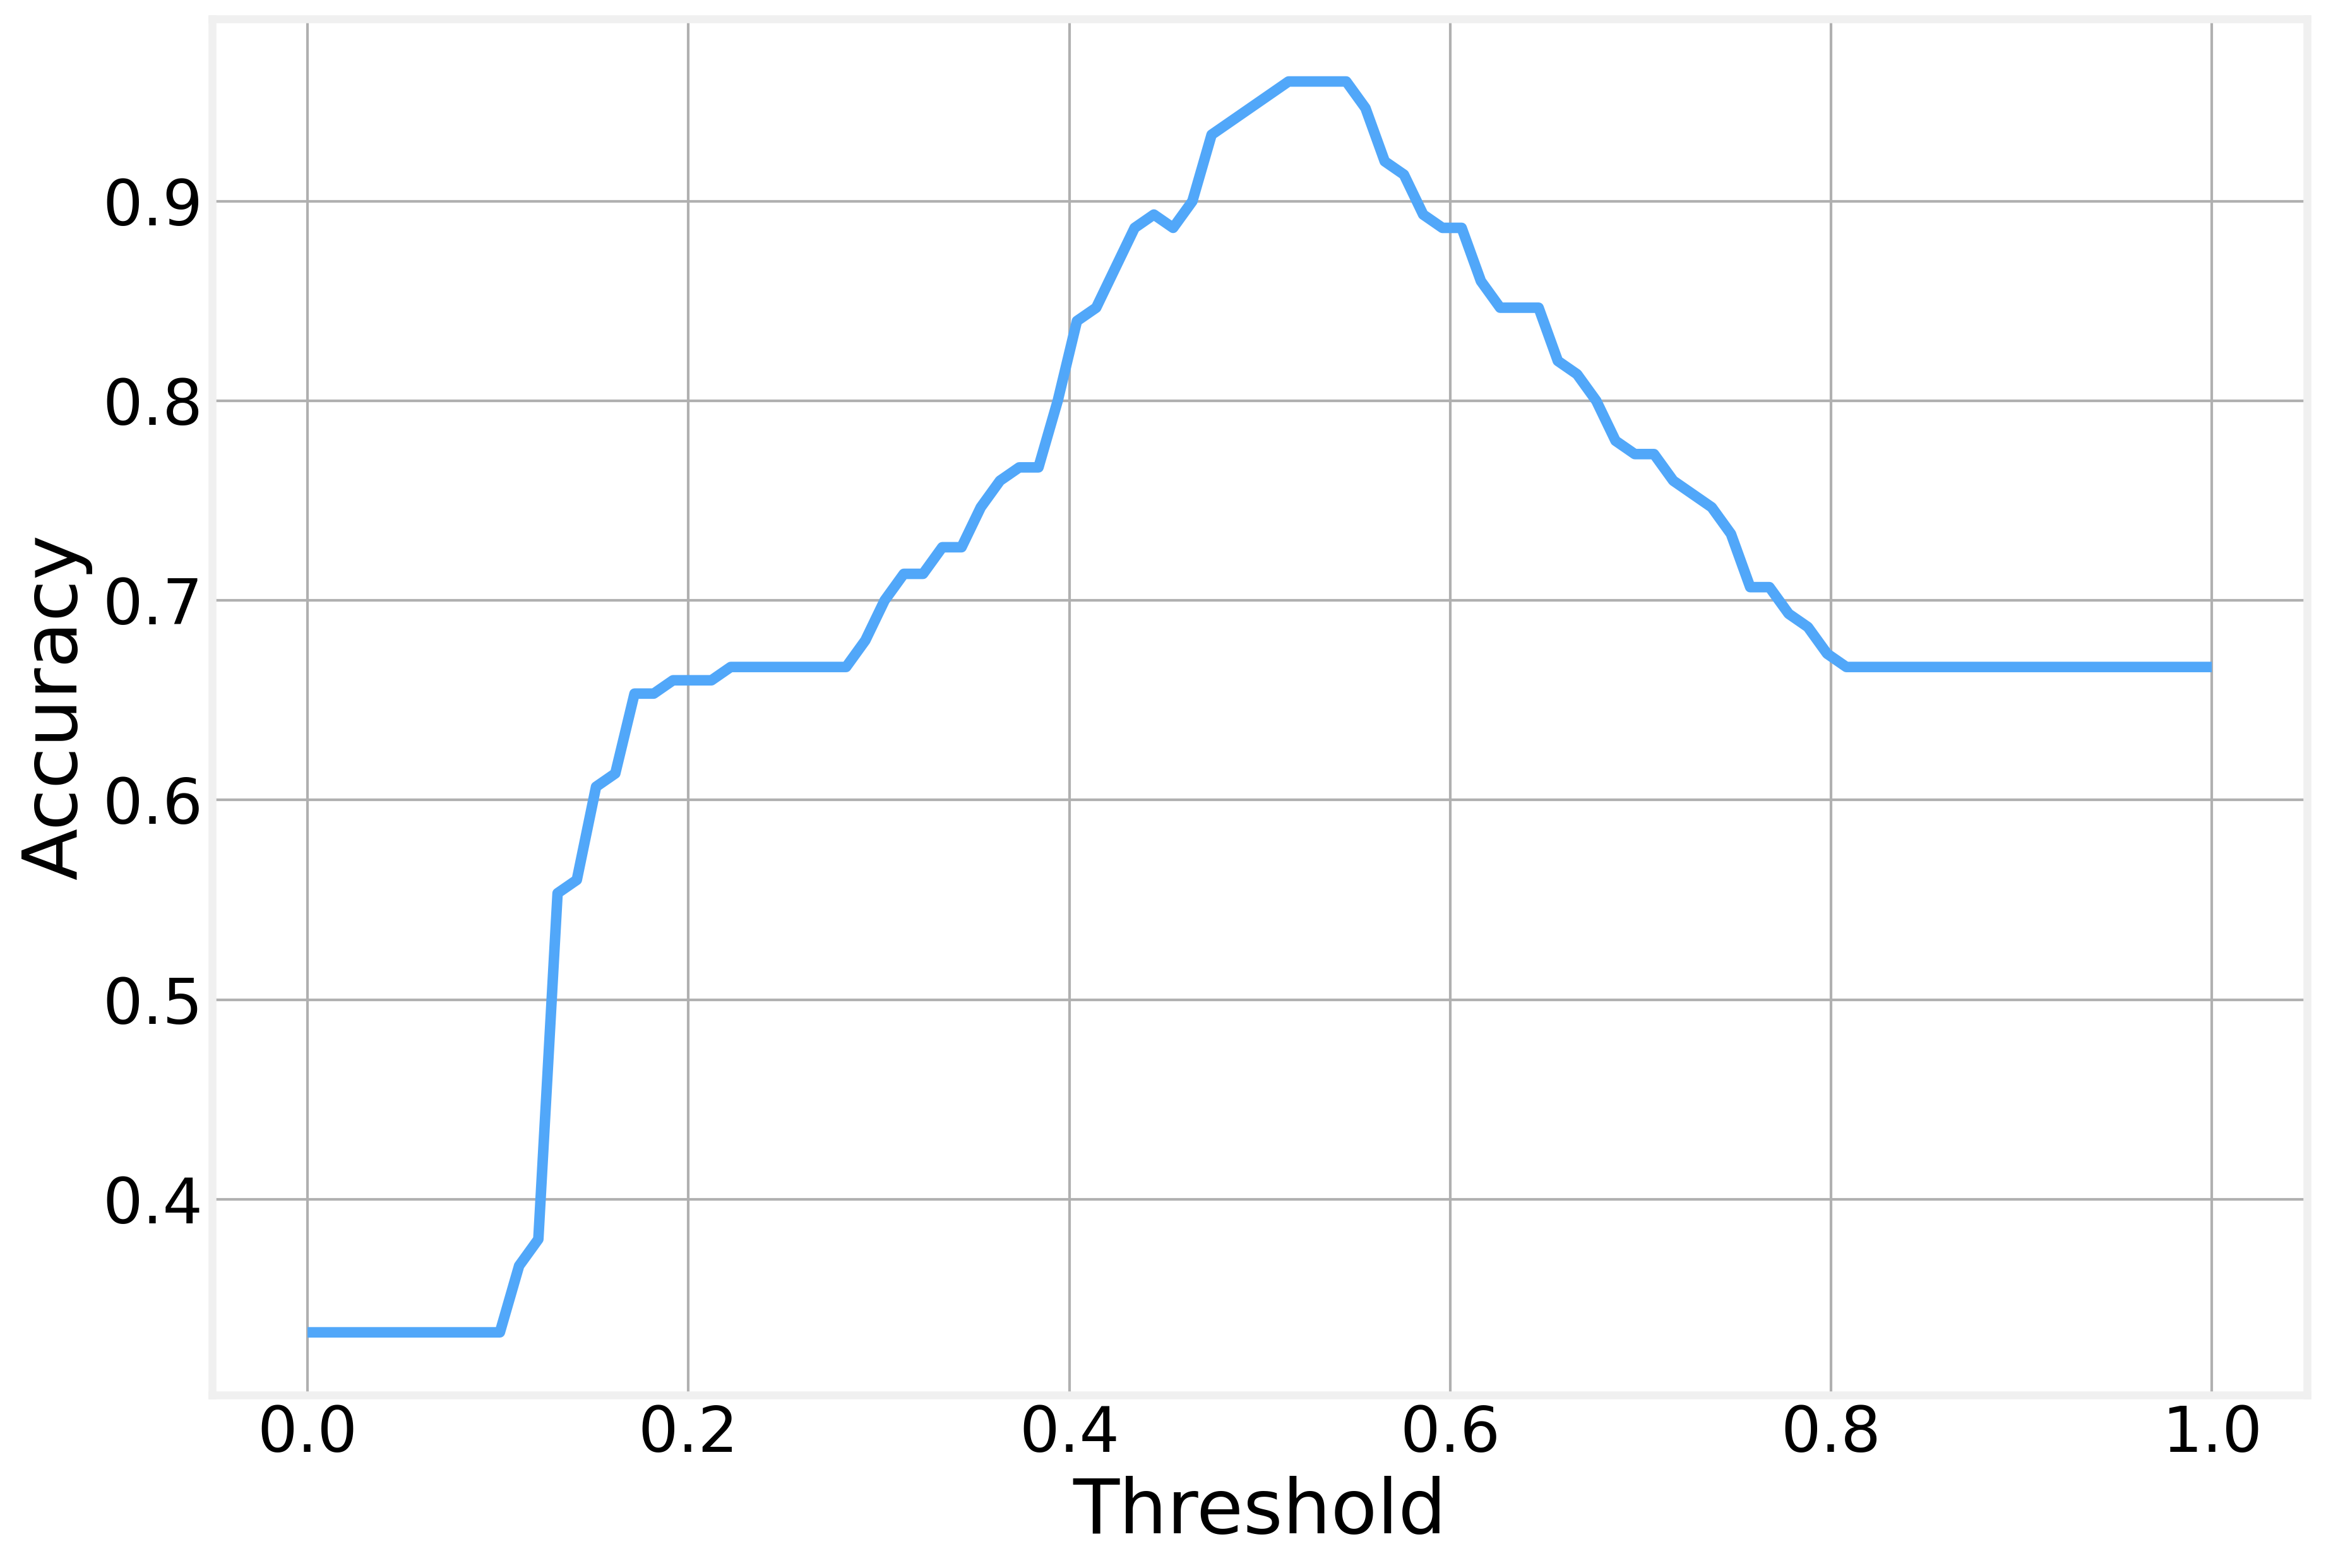

In [44]:
fig, ax = plt.subplots(1)
ax.plot(np.linspace(0, 1, 100), acc)
ax.set_xlabel('Threshold')
ax.set_ylabel('Accuracy')

<center>
     <img src="data/D4Sci_logo_full.png" alt="Data For Science, Inc" border="0" width=300px> 
</center>